In [1]:
import sys
sys.path.insert(0,'/mnt/01D59EBC8D926700/Projects/Digital Race 2020/lane_regression/lane_segmentation/Ultra-Fast-Lane-Detection')

In [23]:
import os
import cv2
import time
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from shutil import copyfile, rmtree

In [24]:
def millis():
    return int(time.time() * 1000)

In [13]:
import torchvision.transforms as transforms
img_transform = transforms.Compose([
        transforms.Resize((288, 800)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

In [22]:
target_folder = './training_images/'
for fld in ['train', 'val']:
    if os.path.exists(target_folder + fld):
        rmtree(target_folder + fld)
    os.mkdir(target_folder + fld)

In [25]:
def get_save_folder():
    rand = np.random.random()
    if rand < 0.2:
        return target_folder + 'val/'
    else:
        return target_folder + 'train/'

In [3]:
def get_all_img(images_link):
    # Get all (image, annotation) from path
    img_links = []
    i = 0
    for f1 in os.listdir(images_link):
        new_path_f1 = os.path.join(images_link, f1)

        for f2 in os.listdir(new_path_f1):
            new_path_f2 = os.path.join(new_path_f1, f2)
            if any(x not in os.listdir(new_path_f2) for x in ['20.png', '20.jpg']):
                i += 1
                continue

            img_link = os.path.join(new_path_f2, '20.jpg')
            anno_link = os.path.join(new_path_f2, '20.png')

            img_links.append((img_link, anno_link))       
    return img_links

In [5]:
images = get_all_img('./../../Data/TUSimple/train_set/clips/')

In [7]:
from lane_detection_inference import LaneInference
lane_model = LaneInference(False, '/mnt/01D59EBC8D926700/Projects/Digital Race 2020/lane_regression/lane_segmentation/Ultra-Fast-Lane-Detection/logs/tusimple_2411_mini.pth')

Inference lane segmentation with torch version 1.7.0


In [30]:
counter = 1
for image_link, label_link in images:
    print('Processing image {} of {}'.format(counter, len(images)), end='\r')
    counter += 1
    image = cv2.imread(image_link)[:, :, (2, 1, 0)]
    prediction = lane_model.predict(image)
    image = img_transform(Image.fromarray(image)).numpy()
    image = np.transpose(image, (1, 2, 0))
    
    file_name = get_save_folder() + str(millis())
    np.savez_compressed(file_name, image=image)
    np.savez_compressed(file_name + '_lbl', image=prediction)
    
#     break

In [39]:
import tensorflow as tf

class NumpyDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images_link, in_dim, out_dim, batch_size=32, shuffle=False):
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.batch_size = batch_size
        self.images_link = images_link
        self.shuffle = shuffle
        self.images = self.get_all_images(images_link)
        self.indexes = None
        self.on_epoch_end()
        print('Data generator on {} images'.format(len(self.images)))

    def get_all_images(self, images_link):
        images = []
        for f in os.listdir(images_link):
            if '_lbl' not in f:
                images.append(images_link + f)
        return images

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.images)//self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        #print('Index: {}'.format(index))
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_images_temp = [self.images[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_images_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_images_temp):
        '''
        Generate data with the specified batch size
        '''
        # Initialization
        X = np.empty((self.batch_size, *self.in_dim, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.out_dim, 4), dtype=np.float32)

        for i, img in enumerate(list_images_temp):
            X[i,] = cv2.resize(np.load(img)['image'], (self.in_dim[1], self.in_dim[0]))
            y[i,] = cv2.resize(np.load(img.replace('.npz', '_lbl.npz'))['image'], (self.out_dim[1], self.out_dim[0]))

        return X, y

In [40]:
datagen = NumpyDataGenerator('./training_images/val/', (144, 400), (18, 50))

Data generator on 1002 images


In [42]:
X, y = datagen.__getitem__(0)

In [43]:
X.shape

(32, 144, 400, 3)

In [44]:
y.shape

(32, 18, 50, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


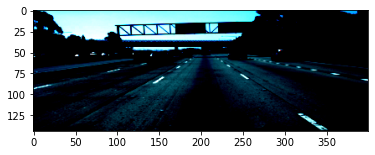

In [45]:
plt.imshow(X[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


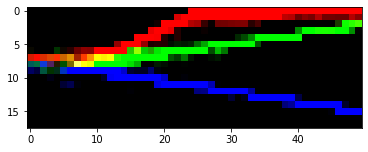

In [48]:
plt.imshow(y[0][:, :, :3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


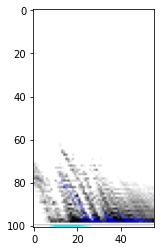

In [47]:
plt.imshow(prediction)